The dataset for this competition (both train and test) was generated from a deep learning model trained on the Machine Failure Predictions

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [112]:
from sklearn.preprocessing import LabelEncoder

In [113]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Exploration

## Target

We are predicting on the `Machine failure` variable, which is binary.

In [114]:
train['Machine failure'].unique()

array([0, 1], dtype=int64)

In [115]:
y = train[['Machine failure']].values.ravel()
type(y)

numpy.ndarray

### Explanation
There is an error that results from using a 1d numpy array 
```
A column-vector y was passed when a 1d array was expected
```
`.values` will give the values in a numpy array (shape: (n,1))
`.ravel` will convert that array shape to (n, ) (i.e. flatten it), resolving the error.

array([[<AxesSubplot:title={'center':'Machine failure'}>]], dtype=object)

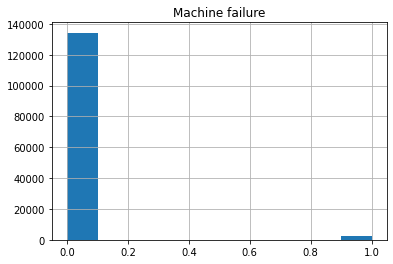

In [116]:
train[['Machine failure']].hist()

The target variable clearly has issues. we will revisit this later on.

In [117]:
# Dropping it from the dataframe
train.drop(columns='Machine failure', inplace=True)
train.shape

(136429, 13)

## Predictors

In [118]:
train.head(2)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0


In [119]:
test.head(2)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0


In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 13.5+ MB


### Object Type

In [121]:
# Object types
train.select_dtypes(include='object').head(2)

,Product ID,Type
0,L50096,L
1,M20343,M


We get rid of the `Product ID` column since it is only meant for identification. In my understanding, there are no patterns to be learned from it.

In [122]:
train.drop(columns='Product ID', inplace=True)

In [123]:
test.drop(columns='Product ID', inplace=True)

As for the `Type` column, we encode it numerically to make it palatable to our ML algorithms.

In [124]:
train.Type.unique()

array(['L', 'M', 'H'], dtype=object)

It has three levels, which will be ideally represented as `0-1` in the same column. We will avoid `one hot encoding` for now to minimize the number of variables. We will use Sci-kit Learn's `labelEncoder`.

In [125]:
LE = LabelEncoder()

train.Type = LE.fit_transform(train.Type)

In [126]:
test.Type = LE.fit_transform(test.Type)

In [127]:
train.Type.unique()

array([1, 2, 0])

In [128]:
train.head(2)

,id,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,0,1,300.6,309.6,1596,36.1,140,0,0,0,0,0
1,1,2,302.6,312.1,1759,29.1,200,0,0,0,0,0


### Numeric Types

We now only have numeric variables left. Perhaps what remains to do is `noemalization` and filtering out missing values.

In [129]:
# train.select_dtypes(exclude='object')

### Missing Values

In [130]:
train.isna().any()

id                         False
Type                       False
Air temperature [K]        False
Process temperature [K]    False
Rotational speed [rpm]     False
Torque [Nm]                False
Tool wear [min]            False
TWF                        False
HDF                        False
PWF                        False
OSF                        False
RNF                        False
dtype: bool

There are no missing values in our dataset, thankfully. Which makes sense since this is a *synthetic dataset*, it isn't raw data from the wild.

### Zero Columns?

The last five columns in the dataset seem to have all their values set to zero at a glance. If so, they may add no value to our model and we may skip them. Let's investigate further.

In [131]:
for column in range(1,6):
    print(train.iloc[:,-column].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Turn out `HDF, PWF, OSF, RNF, TWF` are binary variables.

### Normalization

In [132]:
from sklearn.preprocessing import StandardScaler

In [133]:
SCALE = StandardScaler()

In [152]:
X = SCALE.fit_transform(train)
test = SCALE.fit_transform(test)

### Plots

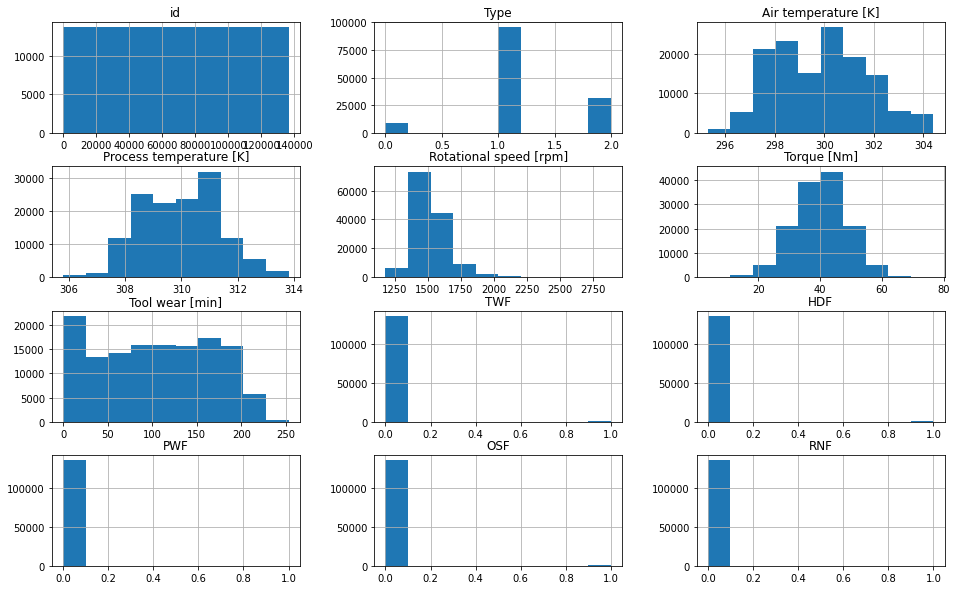

In [153]:
fig = train.hist(figsize=(16,10))

## Imbalanced Variables

The target variable and the variables `HDF, PWF, OSF, RNF, TWF` are inbalanced. They have way more cases in one class than the other. We best be mindful of that as that is likely to affect our learning techniques. Possible effects include:
1. **Bias**. If the target variable is imbalanced the classifiers bias towards the majority class. This can result in `low recall` or `low sensitivity` for the positive class.
2. **Deceptive accuracy**. May be highly accurate on the majority class only. Alternative evaluation metrics such as precision, recall, `F1 score`, or area under the Receiver Operating Characteristic (`ROC`) curve should be used

### Solutions

We are going to attempt to solve this issue by:
- Cross Validation
- Proper weighting of the classes

## Model Training

### Train Test Split
We are going to use the training set for both training and testing.

In [154]:
from sklearn.model_selection import train_test_split

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [156]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score

### Hyperparameter tuning

In [157]:
# Define the model
model = LogisticRegression()

# Define the parameter grid
param_grid = {'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]}

# Define the scoring metric
scorer = make_scorer(f1_score)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=cv)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

Best Parameters:  {'class_weight': None}
Best F1 Score:  0.8649575409352774


### Fitting

In [158]:
model.fit(X_train, y_train)

LogisticRegression()

## Evaluation


In [159]:
from sklearn.metrics import jaccard_score, accuracy_score, log_loss, classification_report

In [160]:
y_pred = model.predict(X_test)
y_pred_logs = model.predict_log_proba(X_test)

In [161]:
accuracy_score(y_test, y_pred=y_pred)

0.995895330938943

In [162]:
jaccard_score(y_test, y_pred=y_pred)

0.7454545454545455

In [163]:
log_loss(y_test, y_pred_logs)

0.6931471805599453

In [164]:
print(classification_report(y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26850
           1       0.99      0.75      0.85       436

    accuracy                           1.00     27286
   macro avg       0.99      0.88      0.93     27286
weighted avg       1.00      1.00      1.00     27286



The model has poor recall on class 1, which has disproportionately fewer samples. This happens at the same time the model has record accuracy. We will have to adjust hyperparameters to raise `recall` for that class.

## Kaggle Predictions

Now we predict on the test set provided by kaggle in order to submit for grading.

In [165]:
test_kaggle = pd.read_csv('./test.csv')

kaggle_preds = model.predict(test)

df = pd.DataFrame({'id' : test_kaggle.id, 'Machine failure' : kaggle_preds})
df.to_csv('./sample_submission.csv', index=False)